## 0) Import Libraries and the Dataset

Setup your python environment and download the credit-score data

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [119]:
credit_card_df = pd.read_csv('Dataset/train_biased.csv')

## 1) Understanding the dataset



### 1.1) General overview of the dataset

Using the function `.head()`, we can extract from the dataset the first x rows (x=5 by default, but we can change this number). They are not useful for analytic purposes, but still enable us to visualize the dataset to get a general overview of the data. 


In [120]:
# Head of the DataFrame
print("Head of the DataFrame:")
print(credit_card_df.head())
print("\n")

# Identify Number of Columns and Rows
n_rows = len(credit_card_df)
n_columns = len(credit_card_df.columns)
print(f"The dataset contains {n_columns} columns")
print(f"The dataset contains {n_rows} rows")


Head of the DataFrame:
       ID Customer_ID     Month           Name    City         Street    Age  \
0     NaN   CUS_0xd40       NaN  Aaron Maashoh  Lonton  Oxford Street    NaN   
1  0x1603   CUS_0xd40  February  Aaron Maashoh  Lonton  Oxford Street   23.0   
2  0x1604   CUS_0xd40       NaN            NaN  Lonton  Oxford Street -500.0   
3  0x1605   CUS_0xd40     April  Aaron Maashoh  Lonton  Oxford Street   23.0   
4     NaN   CUS_0xd40       May  Aaron Maashoh  Lonton  Oxford Street   23.0   

           SSN Occupation Annual_Income  ...  Num_of_Delayed_Payment  \
0  821-00-0265    Manager      19114.12  ...                       7   
1  821-00-0265    Manager      19114.12  ...                     NaN   
2  821-00-0265    Manager      19114.12  ...                       7   
3  821-00-0265    Manager      19114.12  ...                       4   
4  821-00-0265    Manager      19114.12  ...                     NaN   

   Changed_Credit_Limit  Num_Credit_Inquiries  Credit_Mix Outst

We continued our first and superficial analysis of the dataset by retrieving the names of the columns and their data types. This is done using the function `.dtypes`, in order to understand the nature of the data we are dealing with and to check if there are any inconsistencies in the dataset (e.g. a column that should be numeric but is stored as a string). 
In addition, we can also check the number of missing values in each column using the function `.isnull().sum()`. This is useful to understand if we need to impute the dataset before proceeding with the analysis. 
Finally, we can also check the number of unique values in each column using the function `.nunique()`, which is relevant to discover the categorical variables in the dataset.

In [121]:
# Create a DataFrame with column data types and number of unique values
column_summary = pd.DataFrame({
    "Data Type": credit_card_df.dtypes,
    "Unique Values": credit_card_df.nunique(),
    "Missing Values": credit_card_df.isnull().sum(),
})

# Display the combined summary
print(column_summary)

                         Data Type  Unique Values  Missing Values
ID                          object          90058            9942
Customer_ID                 object          12500            9893
Month                       object              8            9938
Name                        object          10139           18887
City                        object              4            9851
Street                      object             31            9920
Age                        float64           1501           14488
SSN                         object          12501           10001
Occupation                  object             21            9944
Annual_Income               object          18438           10094
Monthly_Inhand_Salary      float64          13204           23595
Num_Bank_Accounts          float64            879            9833
Num_Credit_Card            float64           1132           10062
Interest_Rate              float64           1597            9849
Num_of_Loa

In [122]:
# Visualize rows with missing values
missing_values_rows = credit_card_df[credit_card_df.isnull().any(axis=1)]
print(f"Number of rows with missing values: {len(missing_values_rows)}")

Number of rows with missing values: 96690


Many columns, such as **Annual Income**, are classified as categorical. Upon inspecting the dataset, we observed that several of these columns contain special characters like `"_ \@ $"`, which cause the values to be treated as objects instead of numbers. To address this, we replace these special characters with an empty string `''`. This process may introduce new missing values, but it is necessary for accurate analysis. A cell containing only special characters provides no meaningful information and can be reasonably treated as a missing value.

In [123]:
def simple_clean_numeric(df, cols):
    
    """
    Convert specified columns to numeric by removing any non-digit characters 
    (except for period and minus sign) and then converting to numeric.
    
    Parameters:
      df: pandas DataFrame
      cols: List of column names to clean and convert
      
    Returns:
      A new DataFrame with the specified columns cleaned and converted to numeric.
    """
    
    df_clean = df.copy()
    for col in cols:
        if col in df_clean.columns:
            # Convert to string and remove all characters except digits, period, and minus sign.
            cleaned = df_clean[col].astype(str).str.replace(r'[^0-9\.-]', '', regex=True)
            # Convert the cleaned string to numeric (float); unconvertible values become NaN.
            df_clean[col] = pd.to_numeric(cleaned, errors='coerce')
    return df_clean

# List of columns that should be numeric
should_be_numeric = [
    'Annual_Income', 
    'Num_of_Loan', 
    'Num_of_Delayed_Payment', 
    'Changed_Credit_Limit', 
    'Outstanding_Debt', 
    'Amount_invested_monthly'
]

# Clean and convert the data
credit_card_df = simple_clean_numeric(credit_card_df, should_be_numeric)

# Verify that the columns are now numeric
print(credit_card_df[should_be_numeric].dtypes)


Annual_Income              float64
Num_of_Loan                float64
Num_of_Delayed_Payment     float64
Changed_Credit_Limit       float64
Outstanding_Debt           float64
Amount_invested_monthly    float64
dtype: object


After converting the columns to numeric, we can correctly check the data types of the columns again using the function `.dtypes`. This allows us to verify that the columns are now in the appropriate format for analysis, as well as to split the dataset into categorical and numerical variables. 

In [124]:
##Selecting numerical features
numerical_data = credit_card_df.select_dtypes(include='number')
#append the features of numerical_data to list
numerical_features = numerical_data.columns.tolist()

#Selecting categoricalfeatures
categorical_data = credit_card_df.select_dtypes(include= 'object')
#append the features of categorical_data to list
categorical_features = categorical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:')
print(numerical_features)
print('\n')
print(f'There are {len(categorical_features)} categorical features:')
print(categorical_features)

There are 15 numerical features:
['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Amount_invested_monthly', 'Credit_Score']


There are 12 categorical features:
['ID', 'Customer_ID', 'Month', 'Name', 'City', 'Street', 'SSN', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 'Credit_History_Age', 'Payment_of_Min_Amount']


Now that we have all the numerical features in the correct format, we can proceed with a further analysis of the dataset. We can check the summary statistics of the dataset using the function `.describe()`, which provides useful information such as the mean, standard deviation, minimum and maximum values, and quartiles for each numerical column. This is useful to understand the distribution of the data and to identify any potential outliers.

In [125]:
credit_card_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,85512.0,110.226845,6.849076e+02,-500.000000,24.000000,33.000000,42.000000,8.698000e+03
Annual_Income,89906.0,176544.795590,1.429013e+06,7005.930000,19453.050000,37579.750000,72760.040000,2.419806e+07
Monthly_Inhand_Salary,76405.0,4185.789272,3.178561e+03,303.645417,1625.023750,3086.683333,5940.317500,1.520463e+04
Num_Bank_Accounts,90167.0,17.105172,1.177282e+02,-1.000000,3.000000,6.000000,7.000000,1.798000e+03
Num_Credit_Card,89938.0,22.449410,1.290372e+02,0.000000,4.000000,5.000000,7.000000,1.499000e+03
Interest_Rate,90151.0,72.343923,4.656848e+02,1.000000,8.000000,13.000000,20.000000,5.797000e+03
Num_of_Loan,89809.0,3.065116,6.319337e+01,-100.000000,1.000000,3.000000,5.000000,1.496000e+03
Delay_from_due_date,90012.0,21.081156,1.486271e+01,-5.000000,10.000000,18.000000,28.000000,6.700000e+01
Num_of_Delayed_Payment,83782.0,31.041369,2.263703e+02,-3.000000,9.000000,14.000000,18.000000,4.388000e+03
Changed_Credit_Limit,88058.0,10.389097,6.782829e+00,-6.490000,5.340000,9.410000,14.860000,3.697000e+01


We can instantly see that the dataset contains some strange values. As an example, the column **Age** has both negative (minimun value = -500) and very high values (maximum value = 8698). 
It is also possible to note that the target variable **Credit Score** score is more a categorical variable than a continuous one, as it has only 4 unique values. As a consequence, we will convert the target variable into a categorical variable.

In [126]:
# Convert target variable to object type
credit_card_df['Credit_Score'] = credit_card_df['Credit_Score'].astype('object')

# Display the summary statistics for categorical features
credit_card_df.describe(include="object").T

,count,unique,top,freq
ID,90058,90058,0x25fed,1
Customer_ID,90107,12500,CUS_0x8600,8
Month,90062,8,April,11319
Name,81113,10139,Langep,42
City,90149,4,Standhampton,47744
Street,90080,31,Quality Street,5343
SSN,89999,12501,#F%$D@*&8,5008
Occupation,90056,21,Journalist,17002
Type_of_Loan,79688,6260,Not Specified,1272
Credit_Mix,90085,4,Standard,32875


We firstly tried to plot the distribution of numerical variables without addressing outliers or noisy values. However, the presence of outliers and extreme values in the dataset made it difficult to visualize the distribution effectively. 

In [127]:
# Before making changes, we store a copy of the original dataset
credit_card_df_original = credit_card_df.copy()

## 2) Outlier Detection and Removal

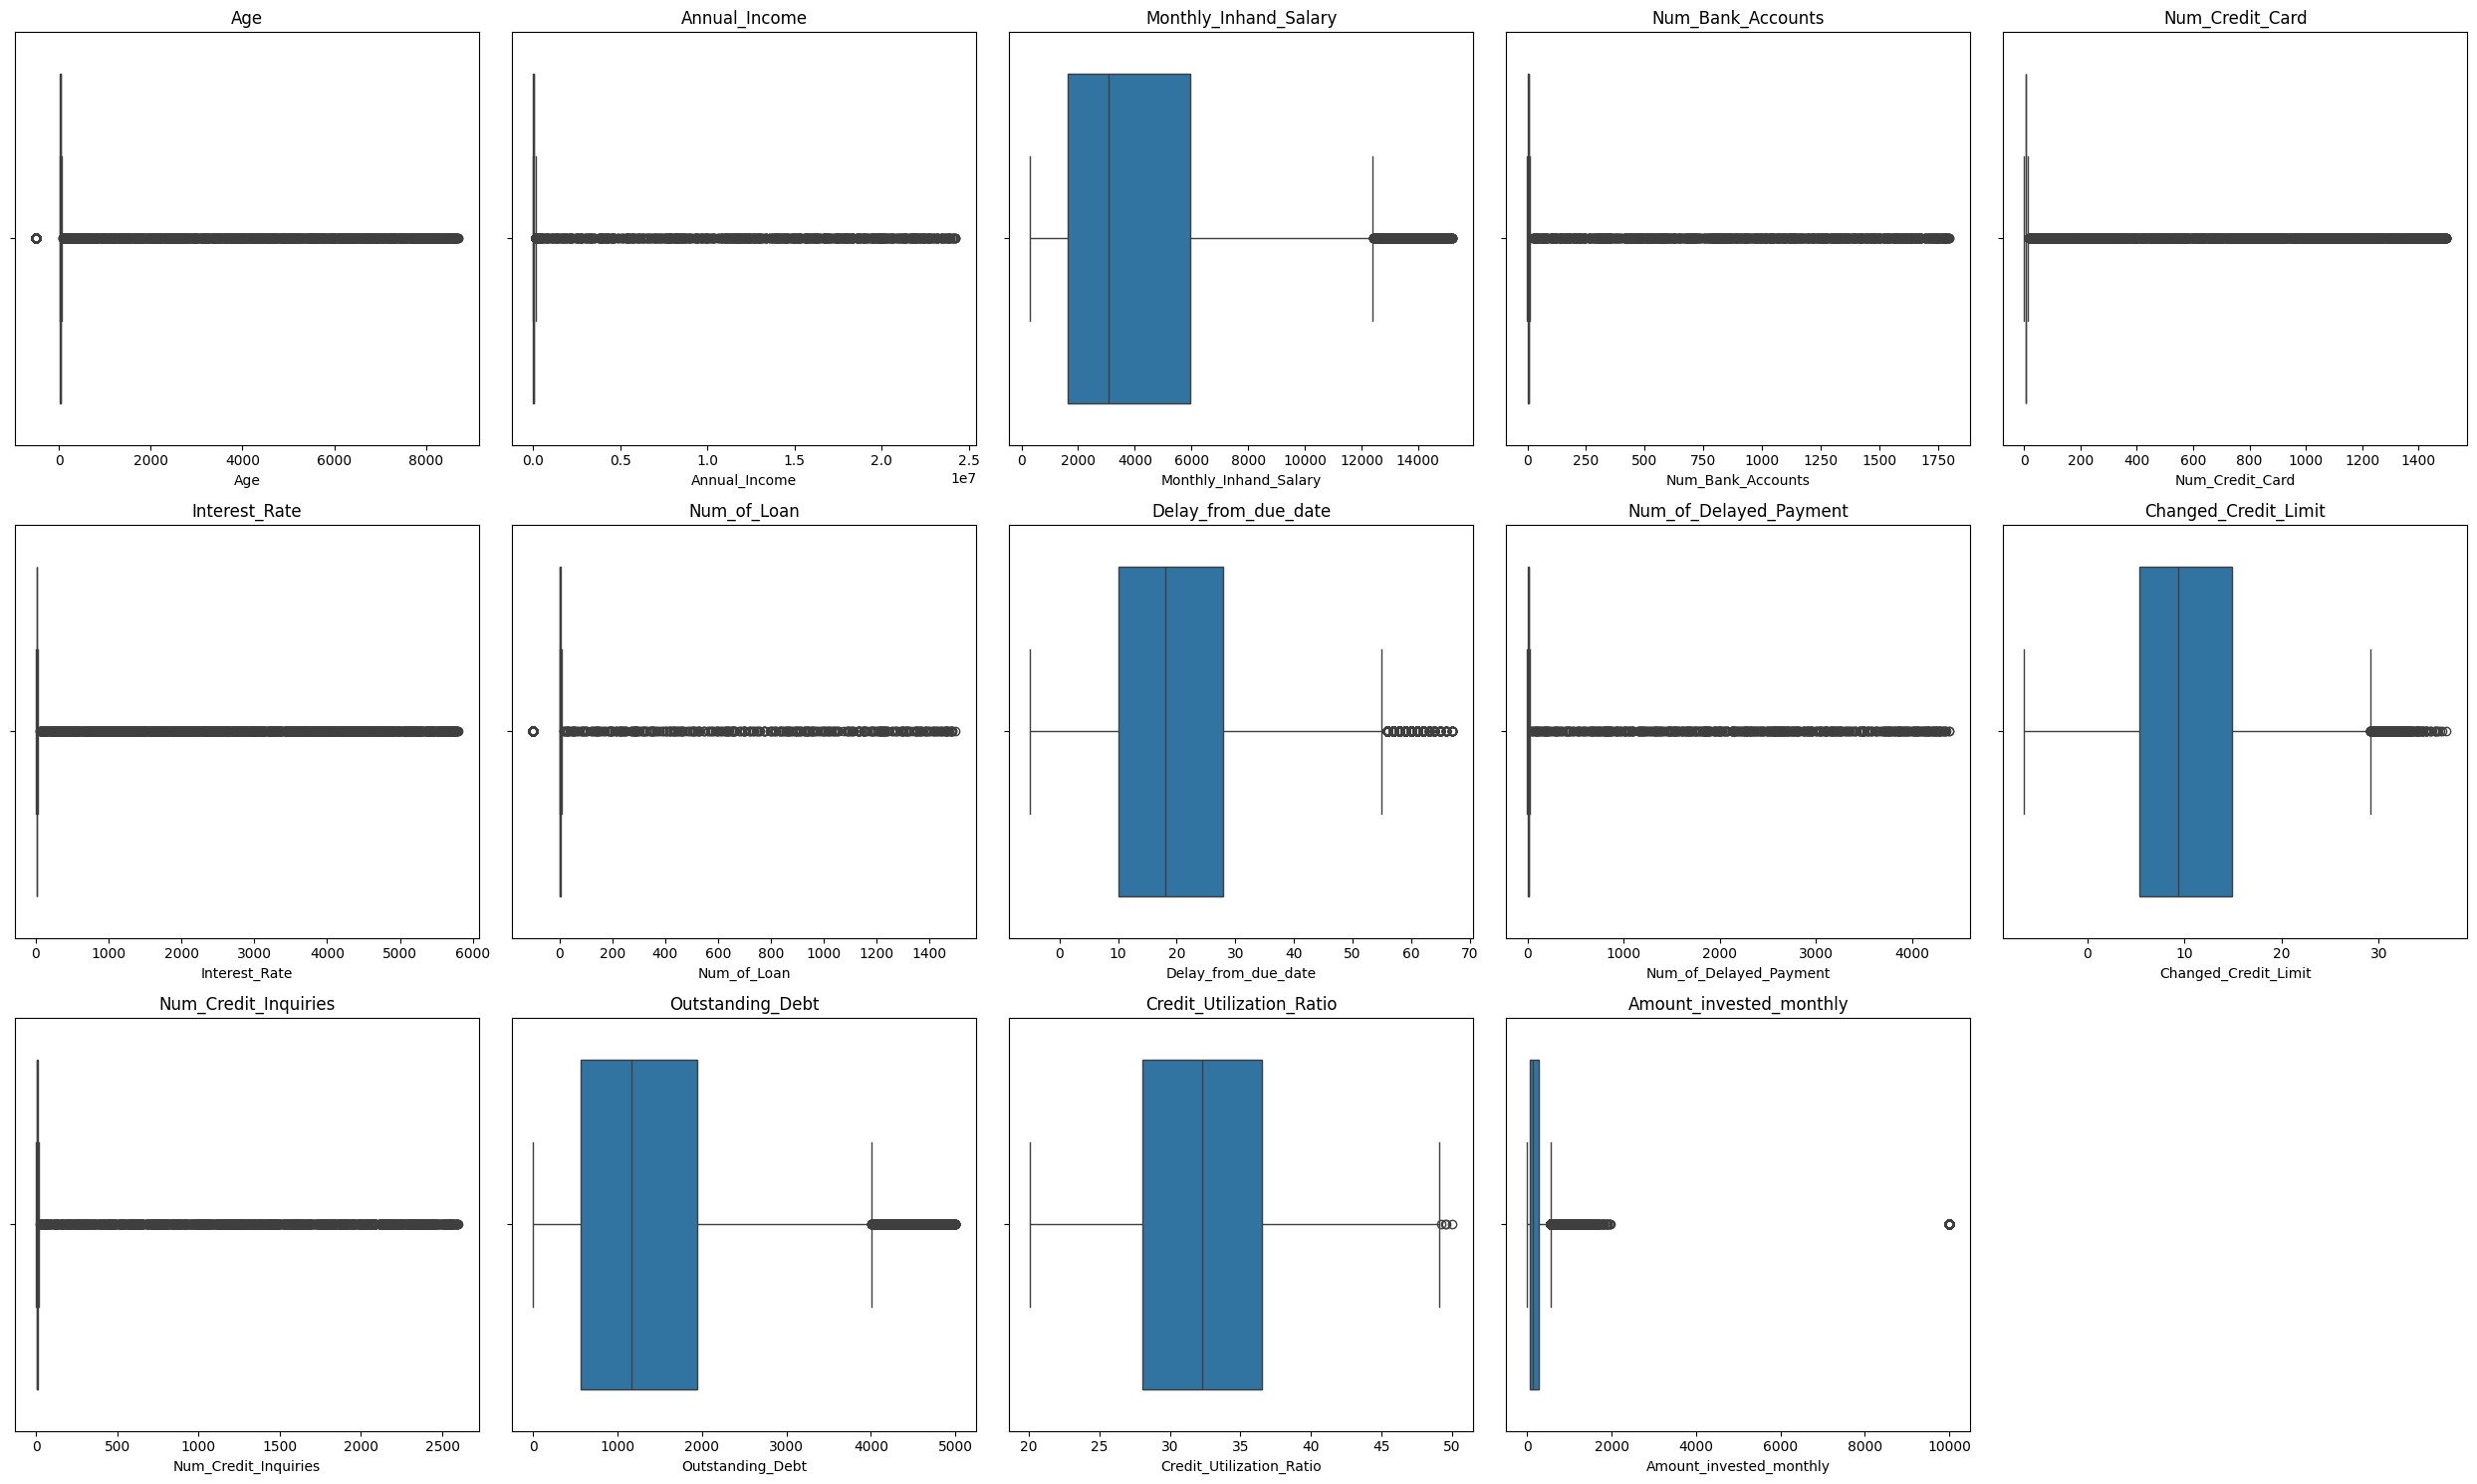

In [128]:
# Assume(numerical_features is your list of columns
n_features = len(numerical_features)
if "Credit_Score" in numerical_features:
    numerical_features.remove('Credit_Score')  # Remove target variable from the list
n_cols = 5  # You can change this based on your preferred layout
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

# Flatten axes for easy indexing
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    # Skip target variable
    sns.boxplot(ax=axes[i], x = credit_card_df[col])
    axes[i].set_title(col)

# Turn off unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [117]:
## Removing outliers from the dataset

def remove_outliers(df, column):
    """
    Remove outliers from a specified column in a DataFrame using the IQR method.
    
    Parameters:
      df: pandas DataFrame
      column: Column name from which to remove outliers
      
    Returns:
      A new DataFrame with outliers removed from the specified column.
    """
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 2.5 * IQR

    # Replace only high outliers with NaN
    df.loc[df[column] > upper_bound, column] = np.nan
    return df

print(f"Shape of the DataFrame before removing outliers: {credit_card_df.shape}")

# Loop through each numerical feature and remove outliers
for col in numerical_features:
    cleaned_credit_card_df = remove_outliers(credit_card_df, col)

Shape of the DataFrame before removing outliers: (100000, 27)


## 2) Missing values imputation

The dataset contains numerous missing values, likely due to poor data collection or entry errors. It is also possible that an event occurred, leading to the loss of many values. However, we observe that there are only 12,500 unique `Customer_ID` values across 100,000 entries. This indicates that many customers are repeated throughout the dataset. Consequently, for missing values that should remain consistent for the same customer, we can impute them using the corresponding values from other rows associated with the same customer.

The first issue to fix is hence to address the missing values in the `Customer_ID` column. 

### 2.1) Imputation of missing values in the `Customer_ID` column

We firstly display the number of missing values in the `Customer_ID` column. 

In [67]:
missing_customerID = credit_card_df['Customer_ID'].isnull().sum()
print(f"Missing Customer_ID: {missing_customerID}")

Missing Customer_ID: 9893


By looking at the dataset we go the impression that each client has a monthly analysis of his credit cards on a range of months that goes from January to August. Consequently, we trid to prove the hypothesis by checking that the number of unique values in the `Customer_ID` column every 8 rows is constant and equal to 1.

Example of correct order:       
| Customer_ID | Month    |
|-------------|----------|
| Client 1    | January  |
| Client 1    | February |
| Client 1    | March    |
| Client 1    | April    |
| Client 1    | May      |
| Client 1    | June     |
| Client 1    | July     |
| Client 1    | August   |

In [68]:
# Check if every 8 rows, the Customer ID is unique
counter = 0
for i in range(0, len(credit_card_df), 8): # Iterate through the DataFrame in steps of 8
    if credit_card_df['Customer_ID'][i:i+7].nunique() > 1: # Check for 8 rows
        print(f"Different Customer ID found in rows {i} to {i+7}")
    # Check the number of misisng values
    if credit_card_df['Customer_ID'][i:i+7].isnull().sum() > 6:
        print(f"Missing Customer IDs found in rows {i} to {i+7}")
    else:
        counter += 1

print(f"Number of times Customer ID is the unique and not missing every 8 rows: {counter}")
print(f"Number of unique Customer IDs: {credit_card_df['Customer_ID'].nunique()}")

Number of times Customer ID is the unique and not missing every 8 rows: 12500
Number of unique Customer IDs: 12500


As we can see, the output of the previous cell shows that the column `Customer_ID` has 12,500 unique values, and each of them is repeated 8 times for the 8 months in which the customer was monitored.
This also implies that there is no customer with a missing `Customer_ID` value, as the number of unique values every 8 rows (which is confirmed to be 1) is equal to the number of unique values in the entire column. As a consequence, there are not wrong entries, but only missing values, that can be easily imputed by taking the unique value of the `Customer_ID` column for each group of 8 rows.

In [69]:
seen_customer_ids = set()

for i in range(0, len(credit_card_df)):
    customer_id = credit_card_df['Customer_ID'][i]
    if customer_id in seen_customer_ids or pd.isnull(customer_id):
        # If the customer ID is already seen or is null we skip this row
        continue
    else:
        # If the customer ID is not seen, we add it to the set
        seen_customer_ids.add(customer_id)
        # We use this customer ID to impute the missing values in the 8 rows of the group
        credit_card_df.loc[(i//8*8) : (i//8*8) + 7, 'Customer_ID'] = customer_id

# Check if there are still any missing values in the Customer_ID column
missing_customerID = credit_card_df['Customer_ID'].isnull().sum()
print(f"Missing Customer_ID after imputation: {missing_customerID}")

Missing Customer_ID after imputation: 0


After the imputation, we can check if the Customer_ID is unique and not missing every 8 rows. We can also check the number of unique Customer IDs in the DataFrame.

In [70]:
# Check that there is still only one unique Customer_ID in every 8 rows nad that there are no missing values
counter = 0
for i in range(0, len(credit_card_df), 8): # Iterate through the DataFrame in steps of 8
    if credit_card_df['Customer_ID'][i:i+7].nunique() > 1: # Check for 8 rows
        print(f"Different Customer ID found in rows {i} to {i+7}")
    else:
        counter += 1
print(f"Number of times Customer ID is the same in 8 rows: {counter}")

missing_customerID = credit_card_df['Customer_ID'].isnull().sum()
print(f"Missing Customer_ID: {missing_customerID}")

Number of times Customer ID is the same in 8 rows: 12500
Missing Customer_ID: 0


### 2.2) Filling the missing values in the `month` column

As we proved in the previous section, the dataset contains 8 months of data for each customer. Here we  fix the remaining missing values for `month` by simply putting the right sequence (from January to August) for each 8 rows (data stored for each customer).

In [71]:
# Define the expected month order.
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']

# Reset the index to ensure we're working on the DataFrame's natural order (if needed)
credit_card_df = credit_card_df.reset_index(drop=True)

# Create a new month column with a repeating cycle: each group of 8 rows gets January to August.
credit_card_df['Month'] = [month_order[i % 8] for i in range(len(credit_card_df))]

# Check Missing Values in the Month Column
missing_month = credit_card_df['Month'].isnull().sum()
print(f"Missing Month values: {missing_month}")

Missing Month values: 0


### 2.3) Filling the columns 'Name', 'City', 'Street' and 'Occupation'

These columns must be filled with the same value for each customer, and hence it is easy to impute them, especially because there are no missing values in the `Customer_ID` column and there are not customers for which one of these information is missing. Just to be sure, we can check the number of unique values in these columns every 8 rows, to confirm that they are all the same for each customer.

In [73]:
# Check that the data is unique every 8 rows
counter_name = 0
counter_city = 0
counter_street = 0
counter_occupation = 0
for i in range(0, len(credit_card_df), 8): # Iterate through the DataFrame in steps of 8
    if credit_card_df['Name'][i:i+7].nunique() > 1:
        # print(f"Different Name found in rows {i} to {i+7}")
        counter_name += 1
    if credit_card_df['City'][i:i+7].nunique() > 1:
        # print(f"Different City found in rows {i} to {i+7}")
        counter_city += 1
    if credit_card_df['Street'][i:i+7].nunique() > 1:
        # print(f"Different Street found in rows {i} to {i+7}")
        counter_street += 1
    if credit_card_df['Occupation'][i:i+7].nunique() > 1:
        # print(f"Different Occupation found in rows {i} to {i+7}")
        counter_occupation += 1

print(f"Number of times Name is different for the same customer: {counter_name}")
print(f"Number of times City is different for the same customer: {counter_city}")
print(f"Number of times Street is different for the same customer: {counter_street}")
print(f"Number of times Occupation is different for the same customer: {counter_occupation}")

Number of times Name is different for the same customer: 0
Number of times City is different for the same customer: 6633
Number of times Street is different for the same customer: 0
Number of times Occupation is different for the same customer: 0


Even though the customer ID is unique every 8 rows and there are not issues with Name, Street and Occupation, meaning that there is a unique value for each customer, the `City` column presents a huge problem. Indeed, considering the output of the previous cell, we can see how more than half of the customers changed city during the 8 months of monitoring at least once. 

As a consequence, we decided to impute the `City` column with the most frequent value for each customer. This is a reasonable approach, as it is likely that the customer lived in that city for most of the time. We can also check how many customers changed city at least once during the 8 months of monitoring.

In [74]:
# Fix the city column
# Impute the City column with the most common city for each Customer_ID
credit_card_df['City'] = credit_card_df.groupby('Customer_ID')['City'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else None))

# Impute missing values in the Name, Street, and Occupation columns
cols_invariant = ['Name', 'Street', 'Occupation']
for col in cols_invariant:
    credit_card_df[col] = credit_card_df.groupby('Customer_ID')[col].transform(lambda x: x.ffill().bfill())

# Check for any remaining missing values in the columns
missing_values = credit_card_df[cols_invariant].isnull().sum()
city_missing_values = credit_card_df['City'].isnull().sum()
print(f"Missing values in invariant columns after filling: {missing_values}")
print(f"Missing values in city column after filling: {city_missing_values}")

Missing values in invariant columns after filling: Name          0
Street        0
Occupation    0
dtype: int64
Missing values in city column after filling: 0



### 2.4) Fixing Age

With the age column, we identified two main issues:

- Inconsistent values across months: For some customers, the age values fluctuate unrealistically between months. For example, in January, a customer might have an age of 23, in February -500 (which is impossible), and in March, it reverts back to 23. We opted to change these impossible values to NaN, as they are not valid ages.
- Age increment due to birthdates between January and August: Many customers have their birthdays between January and August, causing their age to increase by one year during this period. For these cases, it is acceptable to have some rows with one age value (e.g., 54) and others with the incremented value (e.g., 55). 

To handle this, we substiute the missing values or the values that have a difference with the previous one of more than 1 with the value of the previous month. If the latter is not available, we can use the next month value.

In [75]:
# Set impossible values to NaN
credit_card_df.loc[(credit_card_df['Age'] > 90) | (credit_card_df['Age'] < 0), 'Age'] = np.nan

# Impute missing values in the Age column using backward and forward fill
credit_card_df['Age'] = credit_card_df.groupby('Customer_ID')['Age'].ffill().bfill()

# Check for any remaining missing values in the Age column
print(f"Missing Age values after filling: {credit_card_df['Age'].isnull().sum()}")


Missing Age values after filling: 0


To make sure that the filling was done correctly, we can check the number of unique values in the `Age` column every 8 rows. 
If the imputation was successful, we should see that the number of unique values is at most 2, as we have only two possible values for each customer: the age before the birthday and the age after the birthday. Also, in this case, we have to ensure that theages are sorted in ascending order, as it is not possible to have a customer with an age of 23 in January and 22 in February.

In [76]:
# Check that the data is unique or sorted every 8 rows
counter = 0
for i in range(0, len(credit_card_df), 8): # Iterate through the DataFrame in steps of 8
    if credit_card_df["Age"][i:i+7].nunique() > 2: # Check for 8 rows
        print(f"Different values found in rows {i} to {i+7}")
    elif credit_card_df["Age"][i:i+7].nunique() > 1:
        # Check if the values are sorted
        if credit_card_df["Age"][i:i+7].tolist() != sorted(credit_card_df["Age"][i:i+7].tolist()):
            print(f"Values not in the correct order between {i} and {i+7}")
            credit_card_df["Age"][i:i+7] = sorted(credit_card_df["Age"][i:i+7].tolist())
        else:
            counter += 1
    else:
        counter += 1

print(f"Number of times Age is correct in 8 rows: {counter}")


Number of times Age is correct in 8 rows: 12500


### 2.5) Filling Missing SSN Values
The Social Security Number, should uniquely identify a customer. Since a customer's SSN is expected to remain constant over time, any missing or invalid SSN in one row can be reliably filled using a valid SSN from another row belonging to the same customer. We decided to treat this column differently from the others, as it also contains some invalid values.
Firtsly, we defined a function to verify if the SSN matches the standard format (three digits, a dash, two digits, a dash, and four digits). Values that do not meet this pattern or that correspond to known placeholders are set as missing (NaN).
By grouping the data using the Customer_ID, we can apply forward fill and backward fill within each group. This ensures that if at least one valid SSN exists among the 8 rows for the same customer, it is propagated to fill any missing values.

This method leverages the consistency of SSN within each customer group and the sequential structure of the dataset.

In [77]:
# Convert special placeholders into NaN.
def is_valid_ssn(x):
    """
    Checks if x matches the typical SSN format: 3 digits, '-', 2 digits, '-', 4 digits.
    Example: 821-00-0265
    """
    pattern = r'^\d{3}-\d{2}-\d{4}$'
    return bool(re.match(pattern, str(x)))

# Apply the function to the SSN column and set invalid SSNs to NaN
credit_card_df.loc[~credit_card_df['SSN'].apply(is_valid_ssn), 'SSN'] = np.nan

# Impute missing values in the SSN column using the mode
mode_values = credit_card_df.groupby('Customer_ID')["SSN"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
credit_card_df["SSN"] = credit_card_df['Customer_ID'].map(mode_values)

# Check for any remaining missing values in the SSN column
missing_ssn = credit_card_df['SSN'].isnull().sum()
print(f"Missing SSN values after filling: {missing_ssn}")

# Check that the data is unique every 8 rows
counter = 0
for i in range(0, len(credit_card_df), 8): # Iterate through the DataFrame in steps of 8
    if credit_card_df['SSN'][i:i+7].nunique() > 1: # Check for 8 rows
        print(f"Different SSN found in rows {i} to {i+7}")
    else:
        counter += 1

print(f"Number of times SSN is the same in 8 rows: {counter}")
print(f"Number of unique SSNs: {credit_card_df['SSN'].nunique()}")

Missing SSN values after filling: 0
Number of times SSN is the same in 8 rows: 12500
Number of unique SSNs: 12500


### 2.6) Filling Missing Values in Annual Income, Monthly Inhand Salary, Num Bank Accounts, Num Credit Card, Interest Rate and Num of Loan
We suspect that some columns (for example, Annual_Income, Monthly_Inhand_Salary, Num_Bank_Accounts, Num_Credit_Card, Interest_Rate, and Num_of_Loan) should remain constant over the 8 monthly records for each customer. However, there is a possibility that for some columns (such as Monthly_Inhand_Salary) the values might change from month to month. 

To decide if we can impute missing values using the same method as before, we first need to verify that the values in these columns do not vary within the same customer. The code below groups the data by Customer_ID and computes the number of unique values for each candidate column obviously excluding the missing values. This allows us to calculate the percentage of customers that have more than one unique value per column. It also signals the customers for which there is an high variation in the values of the column.

In [78]:
# Define the candidate columns that might be invariant across months for each customer
candidate_cols = [
    "Annual_Income",
    "Monthly_Inhand_Salary",
    "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Interest_Rate",
]

# Check if the values are the same for each customer across all months (8 rows)
flag = False
for col in candidate_cols:
    group_dif= 0
    group_large_dif = 0
    for i in range(0, len(credit_card_df), 8): # Iterate through the DataFrame in steps of 8
        if credit_card_df[col][i:i+7].nunique() > 1: # Check for 8 rows
            # Check the difference between the maximum and minimum values
            # print(f"Column {col} is not invariant across months in rows {i} to {i+7}")
            flag = True
            group_dif += 1
            if credit_card_df[col][i:i+7].max() > credit_card_df[col][i:i+7].dropna().nsmallest(4).mean()*10:
                if group_large_dif == 0:
                    print(f"Column {col} has a large difference in rows {i} to {i+7}")
                group_large_dif += 1     
    print(f"Column {col} has {group_dif} groups with differences and {group_large_dif} groups with large differences.")
    if flag:
        print(f"Column {col} is not invariant across months.")
    else:
        print(f"Column {col} is invariant across months.")




Column Annual_Income has 0 groups with differences and 0 groups with large differences.
Column Annual_Income is invariant across months.
Column Monthly_Inhand_Salary has 616 groups with differences and 0 groups with large differences.
Column Monthly_Inhand_Salary is not invariant across months.
Column Num_Bank_Accounts has a large difference in rows 3440 to 3447
Column Num_Bank_Accounts has 259 groups with differences and 9 groups with large differences.
Column Num_Bank_Accounts is not invariant across months.
Column Num_Credit_Card has 260 groups with differences and 0 groups with large differences.
Column Num_Credit_Card is not invariant across months.
Column Interest_Rate has 0 groups with differences and 0 groups with large differences.
Column Interest_Rate is not invariant across months.


We have seen that the columns `Num_Bank_Accounts`, `Num_Credit_Card`, `Interest_Rate`, and `Num_of_Loan` show different values for the same customer. However, we also noticed that the columns often show a difference between the highest and lowest value that seems to be too high to be considered as a normal variation. As a consequence, we decided to treat these outlies as wrong values, set them to NaN and then impute them together with the other missing values.

To double check the assumption, we verify that there is no customer that has in the following column the specified value as mode:
- Annual income that is greater than 1 million
- Monthly inhand salary greater than 1 million
- Interest rate greater than 100% (of course, this is not possible)
- Number of bank accounts greater than 15
- Number of credit cards greater than 15

In [79]:
# How many times there is a customer with an annual income greater than 1 million as the most frequent value in 8 rows
counter_income = 0
counter_monthly_income = 0
counter_num_bank_accounts = 0
counter_num_credit_card = 0

for i in range(0, len(credit_card_df), 8):  # Iterate through the DataFrame in steps of 8
    # Count how many times the annual income is greater than 1 million
    filter_annual_income = credit_card_df["Annual_Income"][i:i+8] > 1 * 10**6
    filter_monthly_income = credit_card_df["Monthly_Inhand_Salary"][i:i+8] > 1 * 10**5 
    filter_num_bank_accounts = credit_card_df["Num_Bank_Accounts"][i:i+8] > 10
    filter_num_credit_card = credit_card_df["Num_Credit_Card"][i:i+8] > 11

    count_annual_income = filter_annual_income.sum()
    count_monthly_income = filter_monthly_income.sum()
    count_num_bank_accounts = filter_num_bank_accounts.sum()
    count_num_credit_card = filter_num_credit_card.sum()
    
    if count_annual_income > 2:
        # print(f"Annual Income greater than 1 million in rows {i} to {i+7}: {count_annual_income} times")
        counter_income += 1
    
    if count_monthly_income > 0:
        # print(f"Monthly Income greater than 1 million in rows {i} to {i+7}: {count_monthly_income} times")
        counter_monthly_income += 1

    if count_num_bank_accounts > 2:
        # print(f"Num Bank Accounts greater than 15 in rows {i} to {i+7}: {count_num_bank_accounts} times")
        counter_num_bank_accounts += 1

    if count_num_credit_card > 2:
        # print(f"Num Credit Card greater than 15 in rows {i} to {i+7}: {count_num_credit_card} times")
        counter_num_credit_card += 1
    
print(f"Number of times Annual Income is greater than 1 million more than twice for a single customer: {counter_income}")
print(f"Number of times Monthly Income is greater than 1 million more than twice for a single customer: {counter_monthly_income}")
print(f"Number of times Num Bank Accounts is greater than 10 more than twice for a single customer: {counter_num_bank_accounts}")
print(f"Number of times Num Credit Card is greater than 11 more than twice for a single customer: {counter_num_credit_card}")

Number of times Annual Income is greater than 1 million more than twice for a single customer: 0
Number of times Monthly Income is greater than 1 million more than twice for a single customer: 0
Number of times Num Bank Accounts is greater than 10 more than twice for a single customer: 2
Number of times Num Credit Card is greater than 11 more than twice for a single customer: 0


After this check, we can proceed with the deletion of the outliers. 
In addition, we also dropped any value that is negative, as these values are not possible for the columns we are dealing with.

In [80]:
# Exclude impossible values from the dataset

# Replace all negative values in the specified columns with NaN
for col in candidate_cols:
    credit_card_df.loc[credit_card_df[col] < 0, col] = np.nan

# Replace Number of Bank Accounts and Number of Credit Cards with Nan if they are greater than 20
credit_card_df.loc[credit_card_df['Num_Bank_Accounts'] > 10, 'Num_Bank_Accounts'] = np.nan
credit_card_df.loc[credit_card_df['Num_Credit_Card'] > 11, 'Num_Credit_Card'] = np.nan

# Replace Interest Rate with NaN if it is greater than 100%
credit_card_df.loc[credit_card_df['Interest_Rate'] > 100, 'Interest_Rate'] = np.nan

# Replace Annual Income with NaN if it is greater than 1 million
credit_card_df.loc[credit_card_df['Annual_Income'] > 1 * 10**6, 'Annual_Income'] = np.nan

# Replace Monthly Inhand Salary with NaN if it is greater than 1 million
credit_card_df.loc[credit_card_df['Monthly_Inhand_Salary'] > 1 * 10**5, 'Monthly_Inhand_Salary'] = np.nan

After exluding impossible values, we can check again with the previous code if the columns are consistent across the customers.

In [81]:
# Check if the values are the same for each customer across all months (8 rows)
for col in candidate_cols:
    group_dif= 0
    group_large_dif_high = 0
    group_large_dif_small = 0
    for i in range(0, len(credit_card_df), 8): # Iterate through the DataFrame in steps of 8
        if credit_card_df[col][i:i+7].nunique() > 1: # Check for 8 rows
            # Check the difference between the maximum and minimum values
            # print(f"Column {col} is not invariant across months in rows {i} to {i+7}")
            group_dif += 1
            if credit_card_df[col][i:i+7].max() > credit_card_df[col][i:i+7].dropna().nsmallest(4).mean()*10 and credit_card_df[col][i:i+7].dropna().nsmallest(4).mean()!= 0:
                print(f"Column {col} has a large difference in rows {i} to {i+7}")
                group_large_dif_high += 1
            elif credit_card_df[col][i:i+7].nsmallest(4).mean() > credit_card_df[col][i:i+7].max()*10:
                print(f"Column {col} has a large difference in rows {i} to {i+7}")
                group_large_dif += 1    
    print(f"Column {col} has {group_dif} groups with differences, {group_large_dif_high} groups with large differences in the high range and {group_large_dif_small} groups with large differences in the low range.")

Column Annual_Income has 0 groups with differences, 0 groups with large differences in the high range and 0 groups with large differences in the low range.
Column Monthly_Inhand_Salary has 616 groups with differences, 0 groups with large differences in the high range and 0 groups with large differences in the low range.
Column Num_Bank_Accounts has 253 groups with differences, 0 groups with large differences in the high range and 0 groups with large differences in the low range.
Column Num_Credit_Card has 260 groups with differences, 0 groups with large differences in the high range and 0 groups with large differences in the low range.
Column Interest_Rate has 0 groups with differences, 0 groups with large differences in the high range and 0 groups with large differences in the low range.


Since we have few customers that have a varying value for the same column (the maximum is 616 in the case of `Monthly Inhand Salary`), we can impute the missing values using the mode value of the column for each customer.

In [82]:
for col in candidate_cols:
    for i in range(0, len(credit_card_df), 8):  # Iterate through the DataFrame in steps of 8
        mode_values = credit_card_df[col][i:i+7].mode()
        if not mode_values.empty:
            credit_card_df.loc[i:i+7, col] = mode_values.iloc[0]
        else: # Use Annual Income divided by 12 as a fallback
            if credit_card_df['Annual_Income'][i:i+7].mode().empty:
                credit_card_df.loc[i:i+7, col] = np.nan
            else:
                credit_card_df.loc[i:i+7, col] = credit_card_df['Annual_Income'][i:i+7].mode().iloc[0] / 12


# Check for any remaining missing values in the columns
missing_values = credit_card_df[candidate_cols].isnull().sum()
print(f"Missing values in candidate columns after filling: {missing_values}")

# Display the index of the rows with missing values
missing_rows = credit_card_df[credit_card_df[candidate_cols].isnull().any(axis=1)].index.tolist()
print(f"Rows with missing values: {missing_rows}")

Missing values in candidate columns after filling: Annual_Income            0
Monthly_Inhand_Salary    0
Num_Bank_Accounts        0
Num_Credit_Card          0
Interest_Rate            0
dtype: int64
Rows with missing values: []


### 2.7) Filling Missing Values in Type of Loan and Number of Loans
The column `Type_of_Loan` contains categorical values that represent the type of loan a customer has. The column `Number_of_Loan` contains the number of loans a customer has. 

In [83]:
# Check if the values are the same for each customer across all months (8 rows)
counter_n, counter = 0, 0
missing_n, missing = 0, 0
different_n, different = 0, 0
large_dif = 0
for i in range(0, len(credit_card_df), 8): # Iterate through the DataFrame in steps of 8
    if credit_card_df['Type_of_Loan'][i:i+7].nunique() > 1:
        # print(f"Different Type of Loan found in rows {i} to {i+7}")
        different += 1
    elif credit_card_df['Type_of_Loan'][i:i+7].isnull().all():
        # print(f"Type of Loan is all missing in rows {i} to {i+7}")
        # credit_card_df['Type_of_Loan'][i:i+7] = "Not Specified"
        missing += 1
    else:
        counter += 1
    if credit_card_df['Num_of_Loan'][i:i+7].nunique() > 1:
        # print(f"Different Number of Loans found in rows {i} to {i+7}")
        different_n += 1
        if credit_card_df['Num_of_Loan'][i:i+7].max () > credit_card_df['Num_of_Loan'][i:i+7].dropna().nsmallest(4).mean()*10 and credit_card_df['Num_of_Loan'][i:i+7].dropna().nsmallest(4).mean()!= 0:
            # print(f"Column Num_of_Loan has a large difference in rows {i} to {i+7}")
            large_dif += 1
    elif credit_card_df['Num_of_Loan'][i:i+7].isnull().all():
        # print(f"Number of Loans is all missing in rows {i} to {i+7}")
        # credit_card_df['Num_of_Loan'][i:i+7] = 0
        missing_n += 1
    else:
        counter += 1

print(f"Number of times Type of Loan is the same in 8 rows: {counter}")
print(f"Number of times Type of Loan is missing in 8 rows: {missing}")
print(f"Number of times Type of Loan is different in 8 rows: {different}")

print(f"Number of times Number of Loans is the same in 8 rows: {counter}")
print(f"Number of times Number of Loans is missing in 8 rows: {missing_n}")
print(f"Number of times Number of Loans is different in 8 rows: {different_n} and {large_dif} have large differences")
    

Number of times Type of Loan is the same in 8 rows: 20816
Number of times Type of Loan is missing in 8 rows: 1426
Number of times Type of Loan is different in 8 rows: 0
Number of times Number of Loans is the same in 8 rows: 20816
Number of times Number of Loans is missing in 8 rows: 0
Number of times Number of Loans is different in 8 rows: 2758 and 2758 have large differences


As shown by the output of the previous cell, we can see that the column `Type_of_Loan` remains constant for each customer. However, there are some of them for which there is no record at all. They are probably customers that do not have any loan, and for which the column `Num_of_Loan` should be set to 0.
Another aspect that has to be considered is that the results are not consistent: how can a customer have the same list of loans but a different number of loans over the months? Since the latter is not possible, we decided to consider the column `Num_of_Loan` as the one that is more likely to have incorecct values.
We first verify the relation. 

Hence, we can impute the missing values using the mode value of the column for each customer, if it is available, or we can just set the value to "Not Specified" if the customer has no loan at all. We will see later that this is not going to be an issue, since this column and the column `Num_of_Loan` are going to be combined in other columns.

In [84]:
wrong_loan = 0
for i in range(len(credit_card_df)):
    num_loans = credit_card_df['Num_of_Loan'][i]
    loan_type = credit_card_df['Type_of_Loan'][i]
    
    if num_loans == 0 and (loan_type != "Not Specified" and not pd.isna(loan_type)):
        # print(f"Wrong Type of Loan found in row {i}")
        wrong_loan += 1

print(f"Number of times Type of Loan is wrong: {wrong_loan}")    

Number of times Type of Loan is wrong: 0


To prepare the loan-related data for classification, we can begin by imputing missing values in the `Type_of_Loan` column. Since each customer typically has a consistent loan type when specified, we can fill in missing values using the mode (most frequent value) of that column for each individual customer. Next, for rows where the number of loans (`Num_of_Loan`) is missing but the loan type is known, we can estimate the number of loans by counting the occurrences of each loan type per customer. 

In [85]:
# When the Type of Loan is missing, we can use the most frequent value in the group of 8 rows
for i in range(0, len(credit_card_df), 8):  # Iterate through the DataFrame in steps of 8
    mode_values = credit_card_df['Type_of_Loan'][i:i+7].mode()
    # print(f"Mode values for Type of Loan in rows {i} to {i+7}: {mode_values}")
    if not mode_values.empty:
        credit_card_df.loc[i:i+7, 'Type_of_Loan'] = mode_values.iloc[0]
    else: # Use not specified as a fallback
        credit_card_df.loc[i:i+7, 'Type_of_Loan'] = "Not Specified"

# Check for any remaining missing values in the Type of Loan column
missing_type_of_loan = credit_card_df['Type_of_Loan'].isnull().sum()
print(f"Missing Type of Loan values after filling: {missing_type_of_loan}")

Missing Type of Loan values after filling: 0


Finally, to make the `Type_of_Loan` column suitable for classification models, we can expand it into multiple binary or count-based columns—one for each loan type. Each of these new columns will represent how many loans a customer has for that specific type, with a value of zero if they have none. This approach only makes the data more model-friendly, without the need for one-hot-encoding it later on.

In [86]:
# Store the possible values in the 'Type_of_Loan' column
loan_values = credit_card_df['Type_of_Loan'].dropna().str.split(', ').explode().unique()
unique_loan_values = set()
for value in loan_values:
    value = value.replace('and ', '')
    unique_loan_values.add(value)

# Create new columns for each unique loan type
for loan_type in unique_loan_values:
    credit_card_df[loan_type] = credit_card_df['Type_of_Loan'].fillna('').str.count(loan_type)

loan_columns = list(unique_loan_values)
# For rows where Num_of_Loan == 0, set all loan columns to 0
credit_card_df.loc[credit_card_df['Num_of_Loan'] == 0, loan_columns] = 0

# Drop the original 'Type_of_Loan' column
credit_card_df.drop(columns=['Type_of_Loan'], inplace=True)

We can now correct the value in the `Num_of_Loan` column.

In [87]:
# Correct the values in the 'Num_of_Loan' column based on the new loan columns

for i in range(len(credit_card_df)):
    # Get the sum of the new loan columns for the current row
    total_loans = credit_card_df.loc[i, loan_columns].sum()
    
    # Update the 'Num_of_Loan' column with the total number of loans
    credit_card_df.at[i, 'Num_of_Loan'] = total_loans

# Check for any remaining missing values in the loan columns
missing_loan_columns = credit_card_df[loan_columns].isnull().sum()
print(f"Missing values in loan columns after filling:\n{missing_loan_columns}")
# Check for any remaining missing values in the Num_of_Loan column
missing_num_of_loan = credit_card_df['Num_of_Loan'].isnull().sum()
print(f"Missing Num_of_Loan values after filling: {missing_num_of_loan}")

# Put the columns "Num of Loan" and "Credit Score" at the end of the DataFrame
credit_card_df = credit_card_df[[col for col in credit_card_df.columns if col not in ['Num_of_Loan', 'Credit_Score']] + ['Num_of_Loan', 'Credit_Score']]

Missing values in loan columns after filling:
Home Equity Loan           0
Payday Loan                0
Credit-Builder Loan        0
Personal Loan              0
Student Loan               0
Auto Loan                  0
Mortgage Loan              0
Debt Consolidation Loan    0
Not Specified              0
dtype: int64
Missing Num_of_Loan values after filling: 0


### 2.8) Filling Missing Values in Outstanding Debt
The column `Outstanding_Debt` contains numerical values that represent the amount of debt a customer has.

In [88]:
# Check if the values are the same for each customer across all months (8 rows)
counter = 0
for i in range(0, len(credit_card_df), 8): # Iterate through the DataFrame in steps of 8
    if credit_card_df['Outstanding_Debt'][i:i+7].nunique() > 1:
        print(f"Different Outstanding Debt found in rows {i} to {i+7}")
    elif credit_card_df['Outstanding_Debt'][i:i+7].isnull().all():
        print(f"Outstanding Debt is all missing in rows {i} to {i+7}")
    else:
        counter += 1

print(f"Number of times Outstanding Debt is the same in 8 rows: {counter}")

Number of times Outstanding Debt is the same in 8 rows: 12500


Since the column `Outstanding_Debt` is constant for each customer, we can impute the missing values using the mode value of the column for each customer.

In [89]:
# We can use the most frequent value in the group of 8 rows
for i in range(0, len(credit_card_df), 8):  # Iterate through the DataFrame in steps of 8
    mode_values = credit_card_df['Outstanding_Debt'][i:i+7].mode()
    # print(f"Mode values for Outstanding Debt in rows {i} to {i+7}: {mode_values}")
    if not mode_values.empty:
        credit_card_df.loc[i:i+7, 'Outstanding_Debt'] = mode_values.iloc[0]

# Check for any remaining missing values in the columns
missing_values = credit_card_df['Outstanding_Debt'].isnull().sum()
print(f"Missing values in Outstanding Debt after filling: {missing_values}")

Missing values in Outstanding Debt after filling: 0


### 2.9) Filling Missing Values in Credit History
The column `Credit_History_Age` contains categorical values that represent the credit history of a customer. However, these categories are just years and months, which can be converted into a single numerical value (months) in order to make the data more suitable for classification models.

In [90]:
# Transofrm the categorical value (x Years and x Months) into a single value in months
def convert_to_months(x):
    """
    Convert a string in the format 'x Years and y Months' to total months.
    """
    if pd.isnull(x):
        return np.nan
    match = re.match(r'(\d+)\s*Years?\s*and\s*(\d+)\s*Months?', x)
    if match:
        years, months = map(int, match.groups())
        return years * 12 + months
    else:
        return np.nan

# Apply the function to the 'Credit_History_Age' column
credit_card_df['Credit_History_Age'] = credit_card_df['Credit_History_Age'].apply(convert_to_months)

We now check, as we did for the age column, if the values are consistent across the months. This means that we have to check if the values are sorted in ascending order and if there are not two different values for the same customer that differ by more than 8 months.

In [91]:
# Check if the values are sorted every 8 rows (exluding nans)
counter = 0
for i in range(0, len(credit_card_df), 8): # Iterate through the DataFrame in steps of 8
    if credit_card_df['Credit_History_Age'][i:i+7].dropna().tolist() != sorted(credit_card_df['Credit_History_Age'][i:i+7].dropna().tolist()):
            print(f"Values not in the correct order between {i} and {i+7}")
    # Check if the values are all missing
    if credit_card_df['Credit_History_Age'][i:i+7].isnull().all():
        print(f"Credit History Age is all missing in rows {i} to {i+7}")
    # Check if the values min and max differ by more than 8 months
    elif credit_card_df['Credit_History_Age'][i:i+7].max() - credit_card_df['Credit_History_Age'][i:i+7].min() > 7:
        print(f"Credit History Age has a large difference in rows {i} to {i+7}")
    else:
        counter += 1

print(f"Number of times Credit History Age is sequential in 8 rows: {counter}")

Number of times Credit History Age is sequential in 8 rows: 12500


Since we confirmed that each customer has one complete and continuous credit history timeline spread over a group of 8 records, it is possible to fill in the missing values in the `Credit_History_Age` column. 
To do this, we first track which customer IDs we have already processed to avoid duplication. For each unique customer with a known credit history age, we calculate the full range of months that their credit history should cover across the 8 entries. We then fill in the missing values for that customer by assigning a sequence of months that aligns with their credit timeline. This ensures that all entries for a customer reflect a consistent and complete history, helping us preserve useful temporal patterns in the data.

In [92]:
seen_customer_ids = set()
for i in range(0, len(credit_card_df)):  # Iterate through the DataFrame in steps of 8
    customer_id = credit_card_df['Customer_ID'][i]
    credit_history_age = credit_card_df['Credit_History_Age'][i]
    if pd.isnull(credit_history_age):
        # If the credit history age is null, we skip this row
        continue
    elif customer_id in seen_customer_ids:
        # If the customer ID is already seen or is null we skip this row
        continue
    else:
        # If the customer ID is not seen, we add it to the set
        seen_customer_ids.add(customer_id)
        # Compute the range of value in the group of 8 rows
        start = i // 8 * 8
        end = start + 7
        start_month = credit_history_age - (i - start)
        end_month = credit_history_age + (end - i)
        credit_card_df.loc[start:end, 'Credit_History_Age'] = np.arange(start_month, end_month + 1)

# Check for any remaining missing values in the columns
missing_values = credit_card_df['Credit_History_Age'].isnull().sum()
print(f"Missing values in Credit History Age after filling: {missing_values}")

Missing values in Credit History Age after filling: 0


### 2.10) Filling Missing Values in `Amount_Invested_Monthly` and `Credit_Utilization_Ratio`

The column `Amount_Invested_monthly` contains numerical values that represent the amount of money a customer invests each month. `Credit_Utilization_Ratio` contains numerical values that represent the ratio of credit used by a customer.
It is possible that this value changes from month to month. 

In [93]:
# Check how many values are different every 8 rows
counter_inv = 0
counter_credit = 0
counter_inv_missing = 0
counter_credit_missing = 0
for i in range(0, len(credit_card_df), 8): # Iterate through the DataFrame in steps of 8
    if credit_card_df['Amount_invested_monthly'][i:i+7].nunique() > 5:
        # print(f"Different Amount Invested Monthly found in rows {i} to {i+7}")
        counter_inv += 1
    if credit_card_df['Amount_invested_monthly'][i:i+7].isnull().all():
        # print(f"Amount Invested Monthly is all missing in rows {i} to {i+7}")
        # credit_card_df['Amount_invested_monthly'][i:i+7] = 0
        counter_inv_missing += 1
    if credit_card_df['Credit_Utilization_Ratio'][i:i+7].nunique() > 5:
        # print(f"Different Credit Utilization Ratio found in rows {i} to {i+7}")
        counter_credit += 1
    if credit_card_df['Credit_Utilization_Ratio'][i:i+7].isnull().all():
        # print(f"Credit Utilization Ratio is all missing in rows {i} to {i+7}")
        # credit_card_df['Credit_Utilization_Ratio'][i:i+7] = 0
        counter_credit_missing += 1

print(f"Number of times Amount Invested Monthly has 6 or more different values in 8 rows: {counter_inv}")
print(f"Number of times Amount Invested Monthly is all missing in 8 rows: {counter_inv_missing}")
print(f"Number of times Credit Utilization Ratio has 6 or more different values in 8 rows: {counter_credit}")
print(f"Number of times Credit Utilization Ratio is all missing in 8 rows: {counter_credit_missing}")

Number of times Amount Invested Monthly has 6 or more different values in 8 rows: 7191
Number of times Amount Invested Monthly is all missing in 8 rows: 1
Number of times Credit Utilization Ratio has 6 or more different values in 8 rows: 10638
Number of times Credit Utilization Ratio is all missing in 8 rows: 0


Since we confirmed that there are different values (6 or more) for most of the customers, we are sure that it is impossible to have a result that is surely correct. 
As a consequence, we decided to impute the missing values using the mean value of the column for each customer, after excluding the outliers. In this case, we considered as outliers the values that are greater than 9000 (as shown on the distribution we plotted before) and the negative values.

In [94]:
# We iterate through the DataFrame in steps of 8
counter_credit = 0
counter_inv = 0
for i in range(0, len(credit_card_df), 8):
    # If the maxmum value is more than 100 times greater than the minimum value, we set that value to NaN
    if credit_card_df['Amount_invested_monthly'][i:i+7].max() > credit_card_df['Amount_invested_monthly'][i:i+7].dropna().nsmallest(6).mean()*20 and credit_card_df['Amount_invested_monthly'][i:i+7].dropna().nsmallest(6).mean()!= 0:
        # print(f"Amount invested monthly has a large difference in rows {i} to {i+7}") 
        counter_inv += 1
    if credit_card_df['Credit_Utilization_Ratio'][i:i+7].max() > credit_card_df['Credit_Utilization_Ratio'][i:i+7].dropna().nsmallest(6).mean()*5 and credit_card_df['Credit_Utilization_Ratio'][i:i+7].dropna().nsmallest(6).mean()!= 0:
        # print(f"Credit Utilization Ratio has a large difference in rows {i} to {i+7}") 
        counter_credit += 1

print(f"Number of times Amount Invested Monthly has a large difference in 8 rows: {counter_inv}")
print(f"Number of times Credit Utilization Ratio has a large difference in 8 rows: {counter_credit}")

# Remove values that are too high
credit_card_df.loc[credit_card_df['Amount_invested_monthly'] > 9000, 'Amount_invested_monthly'] = np.nan

# Do again the check for the values in the group of 8 rows
counter = 0
for i in range(0, len(credit_card_df), 8): # Iterate through the DataFrame in steps of 8
    if credit_card_df['Amount_invested_monthly'][i:i+7].max() > credit_card_df['Amount_invested_monthly'][i:i+7].dropna().nsmallest(6).mean()*20 and credit_card_df['Amount_invested_monthly'][i:i+7].dropna().nsmallest(6).mean()!= 0:
        # print(f"Credit History Age has a large difference in rows {i} to {i+7}") 
        counter += 1

print(f"Number of times Amount Invested Monthly has a large difference in 8 rows after processing: {counter}")

Number of times Amount Invested Monthly has a large difference in 8 rows: 0
Number of times Credit Utilization Ratio has a large difference in 8 rows: 0
Number of times Amount Invested Monthly has a large difference in 8 rows after processing: 0


Now, it is possible to fill the missing values in the columns 'Amount_invested_monthly' and 'Credit_Utilization_Ratio' using the mean of the group of 8 rows.

In [95]:
# Filling missing values in Amount Invested Monthly using the mean of the customer group

for i in range(0, len(credit_card_df), 8):  # Iterate through the DataFrame in steps of 8
    # Calculate the mean for 'Amount_invested_monthly' and fill missing values
    mean_invested = credit_card_df['Amount_invested_monthly'][i:i+8].mean()
    credit_card_df.loc[i:i+8, 'Amount_invested_monthly'] = credit_card_df['Amount_invested_monthly'][i:i+8].fillna(mean_invested)

    # Calculate the mean for 'Credit_Utilization_Ratio' and fill missing values
    mean_utilization = credit_card_df['Credit_Utilization_Ratio'][i:i+8].mean()
    credit_card_df.loc[i:i+8, 'Credit_Utilization_Ratio'] = credit_card_df['Credit_Utilization_Ratio'][i:i+8].fillna(mean_utilization)

# Check for any remaining missing values in the columns
missing_values = credit_card_df['Amount_invested_monthly'].isnull().sum()
print(f"Missing values in Amount Invested Monthly after filling: {missing_values}")
missing_values = credit_card_df['Credit_Utilization_Ratio'].isnull().sum()
print(f"Missing values in Credit Utilization Ratio after filling: {missing_values}")

Missing values in Amount Invested Monthly after filling: 8
Missing values in Credit Utilization Ratio after filling: 0


### 2.11) Filling Missing Values in `Payment_of_Min_Amount`


The column `Payment_of_Min_Amount` contains categorical values that represent the payment status of a customer. It presents three possible values:
- Yes: the customer paid the minimum amount
- No: the customer did not pay the minimum amount
- NM: stands for "Not Mentioned".

First of all, we verify that there is no customer that has both "Yes" and "No" in the dataset.

In [96]:
# Check the number of unique values for every customer in the group of 8 rows

counter = 0
for i in range(0, len(credit_card_df), 8): # Iterate through the DataFrame in steps of 8
    if credit_card_df['Payment_of_Min_Amount'][i:i+7].nunique() > 2:
        print(f"All the categories are present in rows {i} to {i+7}")
    elif credit_card_df['Payment_of_Min_Amount'][i:i+7].isnull().all():
        print(f"Payment of Minimum Amount is all missing in rows {i} to {i+7}")
    elif credit_card_df['Payment_of_Min_Amount'][i:i+7].nunique() > 1 and "Yes" in credit_card_df['Payment_of_Min_Amount'][i:i+7].values and "No" in credit_card_df['Payment_of_Min_Amount'][i:i+7].values:
        # print(f"Different Payment of Minimum Amount found in rows {i} to {i+7}")
        counter += 1
    else:
        counter += 1

print(f"Number of times Payment of Minimum Amount is the same in 8 rows: {counter}")

Number of times Payment of Minimum Amount is the same in 8 rows: 12500


Since there is no customer that has both "Yes" and "No" in the dataset, we can impute the missing values using the mode value by just setting them to "NM".

In [97]:
# Convert all Nan values to "NM"

credit_card_df['Payment_of_Min_Amount'] = credit_card_df['Payment_of_Min_Amount'].fillna("NM")

### 2.12) Filling Missing Values in `Delay_from_due_date` and `Num_of_Delayed_Payment` and `Changed_Credit_Limit`
The columns `Delay_from_due_date`, `Num_of_Delayed_Payment`, and `Changed_Credit_Limit` contain numerical values that represent the delay from the due date, the number of delayed payments, and the change in credit limit for a customer.

In [98]:
# Check if there are more than 3 different values in the group of 8 rows
counter_dif_delay = 0
counter_dif_num = 0
counter_missing_delay = 0
counter_missing_num = 0
counter_dif_change = 0
counter_missing_change = 0
for i in range(0, len(credit_card_df), 8): # Iterate through the DataFrame in steps of 8
    if credit_card_df['Delay_from_due_date'][i:i+7].nunique() > 3:
        counter_dif_delay += 1
    elif credit_card_df['Delay_from_due_date'][i:i+7].isnull().all():
        counter_missing_delay += 1
    if credit_card_df['Num_of_Delayed_Payment'][i:i+7].nunique() > 3:
        counter_dif_num += 1
    elif credit_card_df['Num_of_Delayed_Payment'][i:i+7].isnull().all():
        counter_missing_num += 1
    if credit_card_df['Changed_Credit_Limit'][i:i+7].nunique() > 3:
        counter_dif_change += 1
    elif credit_card_df['Changed_Credit_Limit'][i:i+7].isnull().all():
        counter_missing_change += 1

print(f"Number of times Delay from Due Date has 4 or more different values in 8 rows: {counter_dif_delay}")
print(f"Number of times Delay from Due Date is all missing in 8 rows: {counter_missing_delay}")
print(f"Number of times Number of Delayed Payment has 4 or more different values in 8 rows: {counter_dif_num}")
print(f"Number of times Number of Delayed Payment is all missing in 8 rows: {counter_missing_num}")
print(f"Number of times Changed Credit Limit has 4 or more different values in 8 rows: {counter_dif_change}")
print(f"Number of times Changed Credit Limit is all missing in 8 rows: {counter_missing_change}")


Number of times Delay from Due Date has 4 or more different values in 8 rows: 2360
Number of times Delay from Due Date is all missing in 8 rows: 0
Number of times Number of Delayed Payment has 4 or more different values in 8 rows: 2609
Number of times Number of Delayed Payment is all missing in 8 rows: 0
Number of times Changed Credit Limit has 4 or more different values in 8 rows: 951
Number of times Changed Credit Limit is all missing in 8 rows: 0


In this case, since there are many customers that present more than 3 different values, we decided to impute the missing values using the mode value of the column for each customer after excluding the outliers.

In [99]:
# Exclude impossible values from the dataset
credit_card_df.loc[credit_card_df['Delay_from_due_date'] < 0, 'Delay_from_due_date'] = np.nan
credit_card_df.loc[credit_card_df['Num_of_Delayed_Payment'] < 0, 'Num_of_Delayed_Payment'] = np.nan

credit_card_df.loc[credit_card_df['Delay_from_due_date'] > 1000, 'Delay_from_due_date'] = np.nan
credit_card_df.loc[credit_card_df['Num_of_Delayed_Payment'] > 50, 'Num_of_Delayed_Payment'] = np.nan



# Filling missing values in Delay from Due Date and Number of Delayed Payment using the mode of the customer group
for i in range(0, len(credit_card_df), 8):  # Iterate through the DataFrame in steps of 8
    mode_value_delay = credit_card_df['Delay_from_due_date'][i:i+7].mode()
    mode_value_num = credit_card_df['Num_of_Delayed_Payment'][i:i+7].mode()
    mode_value_change = credit_card_df['Changed_Credit_Limit'][i:i+7].mode()
    if not mode_value_delay.empty:
        credit_card_df.loc[i:i+7, 'Delay_from_due_date'] = credit_card_df['Delay_from_due_date'].fillna(mode_value_delay.iloc[0])
    if not mode_value_num.empty:
        credit_card_df.loc[i:i+7, 'Num_of_Delayed_Payment'] = credit_card_df['Num_of_Delayed_Payment'].fillna(mode_value_num.iloc[0])
    if not mode_value_change.empty:
        credit_card_df.loc[i:i+7, 'Changed_Credit_Limit'] = credit_card_df['Changed_Credit_Limit'].fillna(mode_value_change.iloc[0])

# Check for any remaining missing values in the columns
missing_values = credit_card_df[['Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit']].isnull().sum()
print(f"Missing values in Delay from Due Date after filling: {missing_values['Delay_from_due_date']}")
print(f"Missing values in Number of Delayed Payment after filling: {missing_values['Num_of_Delayed_Payment']}")
print(f"Missing values in Changed Credit Limit after filling: {missing_values['Changed_Credit_Limit']}")

Missing values in Delay from Due Date after filling: 0
Missing values in Number of Delayed Payment after filling: 0
Missing values in Changed Credit Limit after filling: 0


### 2.13) Filling Missing Values in `Credit_Mix` and `Num_Credit_Inquiries`

The columns `Credit_Mix` and `Num_Credit_Inquiries` contain categorical values that represent the classification of the credit mix and the number of credit inquiries for a customer. As always, we check how and if the values are consistent across the months.

In [100]:
# Check if the values are the same for each customer across all months (8 rows)
counter_mix = 0
counter_mix_missing = 0
counter_mix_dif = 0
counter_inq = 0
counter_inq_missing = 0
counter_inq_dif = 0

# Put all the values "-" to NaN
credit_card_df['Credit_Mix'] = credit_card_df['Credit_Mix'].replace("_", np.nan)

for i in range(0, len(credit_card_df), 8): # Iterate through the DataFrame in steps of 8
    if credit_card_df['Credit_Mix'][i:i+7].nunique() > 1:
        # print(f"Different Credit Mix found in rows {i} to {i+7}")
        counter_mix_dif += 1
    elif credit_card_df['Credit_Mix'][i:i+7].isnull().all():
        # print(f"Credit Mix is all missing in rows {i} to {i+7}")
        counter_mix_missing += 1
    else:
        counter_mix += 1
    if credit_card_df['Num_Credit_Inquiries'][i:i+7].nunique() > 1:
        # print(f"Different Number of Inquiries found in rows {i} to {i+7}")
        counter_inq_dif += 1
    elif credit_card_df['Num_Credit_Inquiries'][i:i+7].isnull().all():
        # print(f"Number of Inquiries is all missing in rows {i} to {i+7}")
        counter_inq_missing += 1
    else:
        counter_inq += 1

print(f"Number of times Credit Mix is the same in 8 rows: {counter_mix}")
print(f"Number of times Number of Inquiries is the same in 8 rows: {counter_inq}")
print(f"Number of times Credit Mix is missing in 8 rows: {counter_mix_missing}")
print(f"Number of times Number of Inquiries is missing in 8 rows: {counter_inq_missing}")
print(f"Number of times Credit Mix is different in 8 rows: {counter_mix_dif}")
print(f"Number of times Number of Inquiries is different in 8 rows: {counter_inq_dif}")

Number of times Credit Mix is the same in 8 rows: 12499
Number of times Number of Inquiries is the same in 8 rows: 6669
Number of times Credit Mix is missing in 8 rows: 1
Number of times Number of Inquiries is missing in 8 rows: 0
Number of times Credit Mix is different in 8 rows: 0
Number of times Number of Inquiries is different in 8 rows: 5831


In this case, the column `Credit_Mix` is constant for each customer (missing in one case), while the column `Num_Credit_Inquiries` presents different values for the same customer. To impute them, we still decided to use the mode value of the column for each customer, as we did for the other columns.

In [101]:
# Drop impossible values from the dataset
credit_card_df.loc[credit_card_df['Num_Credit_Inquiries'] < 0, 'Num_Credit_Inquiries'] = np.nan
credit_card_df.loc[credit_card_df['Num_Credit_Inquiries'] > 20, 'Num_Credit_Inquiries'] = np.nan

# Impute the values in the Credit Mix column using the mode of the customer group
for i in range(0, len(credit_card_df), 8):  # Iterate through the DataFrame in steps of 8
    mode_values = credit_card_df['Credit_Mix'][i:i+7].mode()
    mode_values_inq = credit_card_df['Num_Credit_Inquiries'][i:i+7].mode()
    if not mode_values_inq.empty:
        credit_card_df.loc[i:i+7, 'Num_Credit_Inquiries'] = credit_card_df['Num_Credit_Inquiries'].fillna(mode_values_inq.iloc[0])
    else: # Use 0 as a fallback
        credit_card_df.loc[i:i+7, 'Num_Credit_Inquiries'] = credit_card_df['Num_Credit_Inquiries'].fillna(0)
    if not mode_values.empty:
        credit_card_df.loc[i:i+7, 'Credit_Mix'] = mode_values.iloc[0]
    else: # Use "Good" as a fallback
        credit_card_df.loc[i:i+7, 'Credit_Mix'] = "Standard"

In [105]:
# Save the resulting DataFrame to a new CSV file
credit_card_df.to_csv('Dataset/cleaned_credit_card_data.csv', index=False)